In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf
import common_functions as cf
import keras_tuner as kt

# CNN

In [2]:
def MakeModel(class_names: list) -> tf.keras.Sequential:
    """
    Simple straight forward CNN model. this is just for simplicity and testing
    atm. I will make it more modular later once I know what we are doing

    Args:
        class_names: list of the classification names
        conv_layers: list of how many filters each convolutional layer should use
        layers: list with the sizes of each hidden layer
    
    Returns:
        `tf.keras.Sequential` - a constructed tf model
    """
    tf.keras.backend.clear_session()

    def build_model(hp):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Rescaling(1./255))
        for _ in range(1, hp.Int("num_conv_layers", 1, 2)):
            model.add(tf.keras.layers.Conv2D(hp.Int("conv_filters", 16, 28, 8), 3, kernel_regularizer='l2', activation='relu')) # tf.keras.regularizers.L2(hp.Choice("conv_regularizer", values=[1e-2, 1e-3, 1e-4]))
            model.add(tf.keras.layers.MaxPooling2D())
        model.add(tf.keras.layers.Flatten())
        for _ in range(1, hp.Int("num_layers", 0, 5)):
            model.add(tf.keras.layers.Dense(hp.Int("units", 32, 480, 32), kernel_regularizer='l2', activation='relu')) # tf.keras.regularizers.L2(hp.Choice("conv_regularizer", values=[1e-2, 1e-3, 1e-4]))
        model.add(tf.keras.layers.Dropout(rate=hp.Float("dropout", 0, 0.5, 0.1)))
        model.add(tf.keras.layers.Dense(len(class_names))) # output

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy']
        )
        return model
    return build_model
    

## Load Data

Found 24958 files belonging to 13 classes.
Found 8320 files belonging to 13 classes.
Found 8320 files belonging to 13 classes.


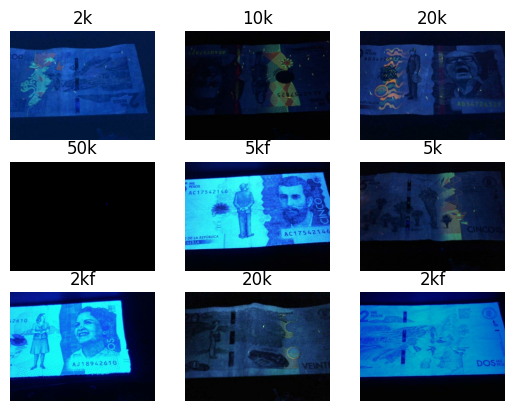

In [3]:
train_ds, test_ds, validation_ds, class_names = cf.LoadData(path = "../Data/Augmented/", batch_size=12)
cf.PeakData(train_ds, class_names)

# Run Hyperparameterization

In [4]:
tuner = kt.Hyperband(MakeModel(class_names),
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='hp_logs/cnn',
                     project_name='augmented_regularized')
tuner.search(
    train_ds, 
    validation_data=validation_ds, 
    epochs=50, 
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
        tf.keras.callbacks.TerminateOnNaN()
    ]
)

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete.
""")
best_hps.values

INFO:tensorflow:Reloading Tuner from hp_logs/cnn/augmented_regularized/tuner0.json
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete.



{'num_conv_layers': 2,
 'num_layers': 1,
 'dropout': 0.2,
 'learning_rate': 0.001,
 'conv_filters': 24,
 'units': 224,
 'tuner/epochs': 4,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 1,
 'tuner/round': 0}

# Find Best Epoch

In [5]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
# .map(cf.AugmentImage(contrast=1))
model = tuner.hypermodel.build(best_hps)
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=15
)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/15
2080/2080 [==============================] - 98s 44ms/step - loss: 1.5800 - accuracy: 0.7432 - val_loss: 0.2383 - val_accuracy: 0.9500
Epoch 2/15
2080/2080 [==============================] - 93s 45ms/step - loss: 0.1492 - accuracy: 0.9726 - val_loss: 0.1695 - val_accuracy: 0.9614
Epoch 3/15
2080/2080 [==============================] - 90s 43ms/step - loss: 0.1051 - accuracy: 0.9825 - val_loss: 0.1677 - val_accuracy: 0.9584
Epoch 4/15
2080/2080 [==============================] - 87s 42ms/step - loss: 0.0884 - accuracy: 0.9843 - val_loss: 0.1257 - val_accuracy: 0.9677
Epoch 5/15
2080/2080 [==============================] - 87s 42ms/step - loss: 0.0763 - accuracy: 0.9855 - val_loss: 0.1053 - val_accuracy: 0.9730
Epoch 6/15
2080/2080 [==============================] - 87s 42ms/step - loss: 0.0639 - accuracy: 0.9886 - val_loss: 0.1120 - val_accuracy: 0.9712
Epoch 7/15
2080/2080 [==============================] - 87s 42ms/step - loss: 0.0580 - accuracy: 0.9894 - val_loss: 0.1183 -

# Fit the Best Model

In [6]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
history = hypermodel.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=best_epoch
)

Epoch 1/5
2080/2080 [==============================] - 88s 42ms/step - loss: 1.4998 - accuracy: 0.8098 - val_loss: 0.2096 - val_accuracy: 0.9577
Epoch 2/5
2080/2080 [==============================] - 87s 42ms/step - loss: 0.1335 - accuracy: 0.9780 - val_loss: 0.1674 - val_accuracy: 0.9619
Epoch 3/5
2080/2080 [==============================] - 86s 42ms/step - loss: 0.1050 - accuracy: 0.9816 - val_loss: 0.1539 - val_accuracy: 0.9648
Epoch 4/5
2080/2080 [==============================] - 86s 41ms/step - loss: 0.0902 - accuracy: 0.9828 - val_loss: 0.1059 - val_accuracy: 0.9743
Epoch 5/5
2080/2080 [==============================] - 86s 41ms/step - loss: 0.0723 - accuracy: 0.9870 - val_loss: 0.1122 - val_accuracy: 0.9703


# Evaluate

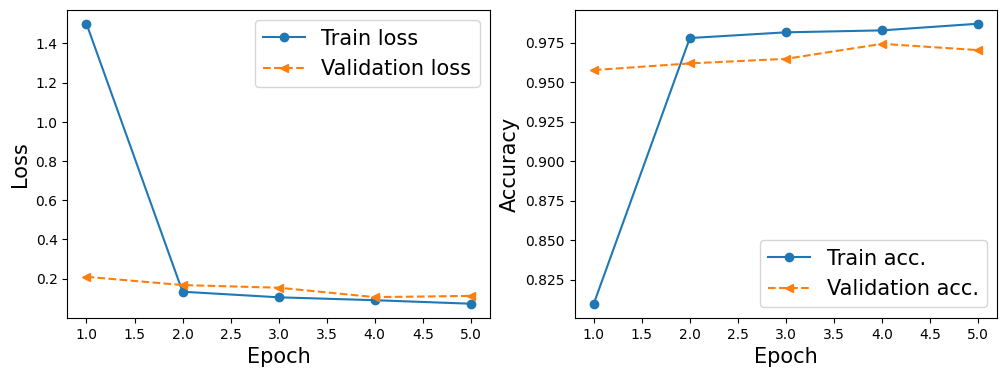

694/694 - 15s - loss: 0.1198 - accuracy: 0.9691 - 15s/epoch - 21ms/step
Test loss: 0.11976955831050873 | Test accuracy: 0.9691105484962463


(0.9870181679725647, 0.9703124761581421, 0.9691105484962463)

In [7]:
cf.EvaluateModel(hypermodel, test_ds, history)

Macro averaged precision score: 0.9641826923076923
Macro averaged recall score: 0.9652142210551303
Macro averaged F1 score: 0.9644059873637649


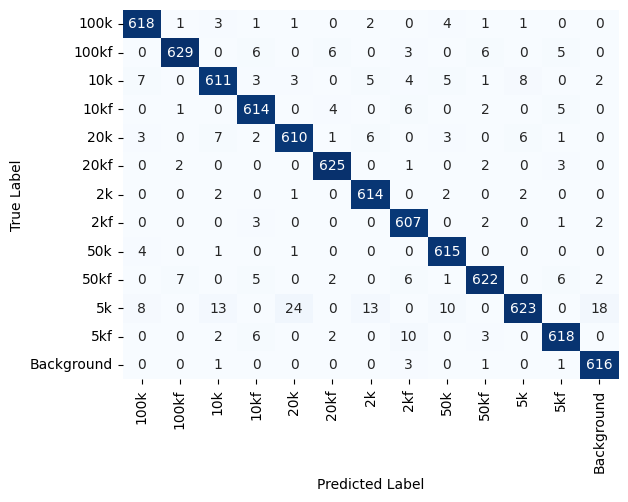

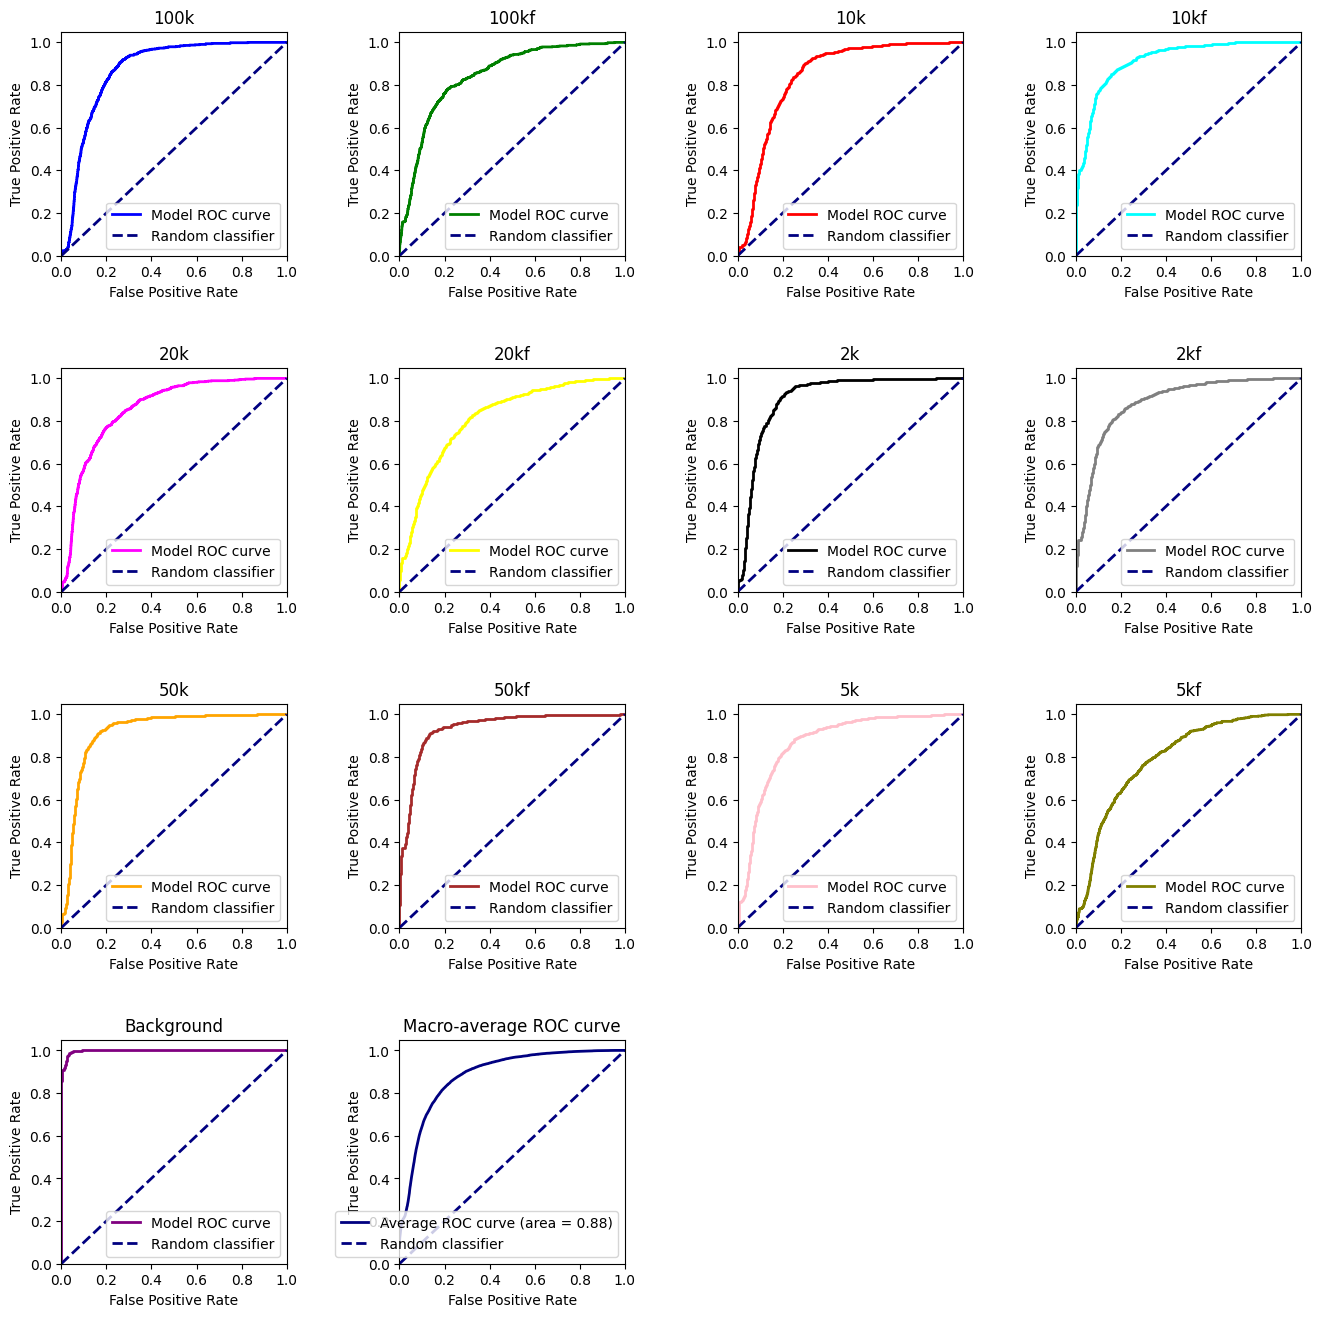

In [8]:
cf.precision_recall_metrics(model, test_ds, class_names)

# Results

grayscale, no augmentation, hyperparameterized (no regularization) = 0.995 trained, 0.9957 test

no grayscale, no augmentation, hyperparameterized (regularization) = 0.9885 trained, 0.9567 validation, 0.9596 test

no grayscale, with augmented images, hyperparameterized, no regularization = 0.9887 trained, 0.9644 validation, 0.9630 test

no grayscale, with augmented images, hyperparamaetereized, with regularization = 0.9907 trained, 0.9709 validation, 0.9709 test

no grayscale, with augmented images, hyperparameterized, with regularization (2nd test) = 0.9931 trained, 0.9738 validation, 0.9745 test

**no grayscale, with augmented images, hyperparameterized, with regularization (3nd test, most recent) = 0.9870 train, 0.9703 validation, 0.9691 test**

- Macro averaged precision score: 0.9641826923076923
- Macro averaged recall score: 0.9652142210551303
- Macro averaged F1 score: 0.9644059873637649
